# 승촌보 데이터 분석

- 승촌보 수질 데이터
    - 2012-2022
    - 시간 단위 수집 데이터
- 승촌보 유량 데이터
    - 2012-2022
    - 10분 단위 수집 데이터

**필수 라이브러리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

**matplotlib 한글 설정**

- 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원.
- 참고: [matplotlib에서 한글 지원하기](https://github.com/codingalzi/datapy/blob/master/matplotlib-korean.md)

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

그레이디언트 부스팅 모델을 활용한다.

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

표준화 라이브러리도 준비한다.

In [4]:
from sklearn.preprocessing import StandardScaler

## 승촌보 수질 데이터 불러오기

- 2012년부터 2022년까지
- 시간 단위 수집 데이터

**데이터 저장소**

In [5]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/data/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

승촌보 데이터를 불러온다. 
`'측정일/월'` 특성은 date time으로 파싱한다.

In [6]:
scb_yearly = pd.read_excel(base_path+"Seungchonbo.xlsx", 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

`scb_yearly`는 연도별 데이터프레임을 갖는 사전 자료형이다.

In [7]:
type(scb_yearly)

dict

년도가 키(key)로 사용된다.

In [8]:
scb_yearly.keys()  # 2012년부터 2022년까지

dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])

년도별 특성은 모두 동일하며 다음과 같다.

In [9]:
list(scb_yearly['2012년'].columns)

['측정일/월',
 '측정소명',
 '수온 ℃',
 '수소이온농도',
 '전기전도도 μS/cm',
 '용존산소 mg/L',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '클로로필-a mg/㎥']

예를 들어 2013년 데이터는 다음과 같다.

In [10]:
scb_yearly['2013년']

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00:00:00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01:00:00,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02:00:00,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03:00:00,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04:00:00,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
8745,2013-12-31 19:00:00,용봉,6.1,6.7,414.0,8.0,3.9,6.523,0.058,10.3
8746,2013-12-31 20:00:00,용봉,6.1,6.7,416.0,7.8,3.8,6.489,0.059,9.9
8747,2013-12-31 21:00:00,용봉,6.1,6.7,416.0,7.9,3.5,6.522,0.058,10.0
8748,2013-12-31 22:00:00,용봉,5.9,6.7,413.0,8.3,3.5,6.600,0.056,11.7


In [11]:
scb_yearly['2013년'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   측정일/월        8750 non-null   datetime64[ns]
 1   측정소명         8750 non-null   object        
 2   수온 ℃         8052 non-null   float64       
 3   수소이온농도       8052 non-null   float64       
 4   전기전도도 μS/cm  8050 non-null   float64       
 5   용존산소 mg/L    7935 non-null   float64       
 6   총유기탄소 mg/L   8042 non-null   float64       
 7   총질소 mg/L     5993 non-null   float64       
 8   총인 mg/L      6048 non-null   float64       
 9   클로로필-a mg/㎥  7109 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 683.7+ KB


`'측정일/월'` 특성을 '년-월-일 시' 형식으로 변경한다.

In [12]:
for year in list(scb_yearly.keys())[1:]:
    scb_yearly[year]['측정일/월'] = scb_yearly[year]['측정일/월'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [13]:
scb_yearly['2013년']

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
8745,2013-12-31 19,용봉,6.1,6.7,414.0,8.0,3.9,6.523,0.058,10.3
8746,2013-12-31 20,용봉,6.1,6.7,416.0,7.8,3.8,6.489,0.059,9.9
8747,2013-12-31 21,용봉,6.1,6.7,416.0,7.9,3.5,6.522,0.058,10.0
8748,2013-12-31 22,용봉,5.9,6.7,413.0,8.3,3.5,6.600,0.056,11.7


**연도별 수질 데이터 통합**

2012년도 데이터를 제외한 모든 데이터를 통합한다.

In [14]:
scb_yearly_df13 = pd.DataFrame()

for year in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[year]])

In [15]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
3427,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
3428,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
3429,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
3430,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


인덱스를 리셋한다. 기존 인덱스는 제거한다.

In [16]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

In [17]:
scb_yearly_df13

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
82252,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
82253,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


In [18]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


**결측치 확인**

측정일과 측정소를 제외한 모든 특성에 다수의 결측치가 포함된다.

In [19]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

## 승촌보 유량 데이터 추가

- 2012년부터 2022까지
- 10분 단위 수집 데이터

**승촌보 유량 데이터 불러오기**

`'시간'` 특성은 date time으로 파싱해서 불러온다.

In [20]:
scb_flow_yearly = pd.read_excel(base_path+"Seungchonbo_flow.xlsx", 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`scb_flow_yearly` 또한 연도별 데이터프레임을 갖는 사전이다.

In [21]:
scb_flow_yearly.keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])

예를 들어, 2013년 수량 데이터는 다음과 같다.

In [22]:
scb_flow_yearly["2013"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   시간           52560 non-null  datetime64[ns]
 1    상류수위(EL.m)  52560 non-null  float64       
 2    하류수위(EL.m)  52560 non-null  float64       
 3    유입량(㎥/s)    52560 non-null  float64       
 4    방류량(㎥/s)    52560 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB


In [23]:
scb_flow_yearly["2013"].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00:00:00,7.5,3.77,19.82,19.74
1,2013-01-01 00:10:00,7.5,3.77,19.78,19.76
2,2013-01-01 00:20:00,7.5,3.77,19.77,19.82
3,2013-01-01 00:30:00,7.5,3.77,19.77,19.73
4,2013-01-01 00:40:00,7.5,3.77,19.78,19.79
5,2013-01-01 00:50:00,7.5,3.77,19.72,19.65
6,2013-01-01 01:00:00,7.5,3.77,19.67,19.58
7,2013-01-01 01:10:00,7.5,3.77,19.61,19.60
8,2013-01-01 01:20:00,7.5,3.77,19.61,19.66
9,2013-01-01 01:30:00,7.5,3.77,19.68,19.77


**시간 단위 데이터로 변환**

10분 단위로 수집된 수량 데이터를 시간 단위 데이터로 변환한다.
단,  데이터가 적은 2012년도 데이터는 무시한다.

- `'시간'` 특성을 '년-월-일 시' 형식으로 변경한다.

In [24]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['시간'] = scb_flow_yearly[year]['시간'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [25]:
scb_flow_yearly['2013'].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.5,3.77,19.82,19.74
1,2013-01-01 00,7.5,3.77,19.78,19.76
2,2013-01-01 00,7.5,3.77,19.77,19.82
3,2013-01-01 00,7.5,3.77,19.77,19.73
4,2013-01-01 00,7.5,3.77,19.78,19.79
5,2013-01-01 00,7.5,3.77,19.72,19.65
6,2013-01-01 01,7.5,3.77,19.67,19.58
7,2013-01-01 01,7.5,3.77,19.61,19.60
8,2013-01-01 01,7.5,3.77,19.61,19.66
9,2013-01-01 01,7.5,3.77,19.68,19.77


- 시간대별 평균 수량으로 구성된 데이터셋 구현한다. 즉, 시 기준 데이터로 변환한다.

In [26]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간').mean()

In [27]:
scb_flow_yearly_hour['2013']

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2013-01-01 00,7.50,3.770000,19.773333,19.748333
2013-01-01 01,7.50,3.770000,19.701667,19.706667
2013-01-01 02,7.50,3.770000,19.748333,19.723333
2013-01-01 03,7.50,3.770000,19.613333,19.610000
2013-01-01 04,7.50,3.770000,19.661667,19.665000
...,...,...,...,...
2013-12-31 19,7.52,3.558333,10.901667,10.910000
2013-12-31 20,7.52,3.555000,10.845000,10.843333
2013-12-31 21,7.52,3.551667,10.850000,10.845000


- 인덱스 추가

In [28]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [29]:
scb_flow_yearly_hour['2013'].head(10)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.500000,3.77,19.773333,19.748333
1,2013-01-01 01,7.500000,3.77,19.701667,19.706667
2,2013-01-01 02,7.500000,3.77,19.748333,19.723333
3,2013-01-01 03,7.500000,3.77,19.613333,19.610000
4,2013-01-01 04,7.500000,3.77,19.661667,19.665000
5,2013-01-01 05,7.500000,3.77,19.641667,19.635000
6,2013-01-01 06,7.500000,3.77,19.573333,19.566667
7,2013-01-01 07,7.491667,3.77,16.646667,19.496667
8,2013-01-01 08,7.490000,3.77,19.495000,19.500000
9,2013-01-01 09,7.486667,3.77,17.576667,19.478333


**승촌보 수량 통합 데이터**

2013년 이후의 연도별 데이터를 모두 통합한다. 

In [30]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [31]:
scb_flow_yearly_hour_df

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.500000,3.770000,19.773333,19.748333
1,2013-01-01 01,7.500000,3.770000,19.701667,19.706667
2,2013-01-01 02,7.500000,3.770000,19.748333,19.723333
3,2013-01-01 03,7.500000,3.770000,19.613333,19.610000
4,2013-01-01 04,7.500000,3.770000,19.661667,19.665000
...,...,...,...,...,...
5487,2022-08-17 15,5.536667,1.618333,29.261667,25.190000
5488,2022-08-17 16,5.525000,1.638333,23.243333,38.923333
5489,2022-08-17 17,5.483333,1.626667,29.068333,44.878333
5490,2022-08-17 18,5.470000,1.566667,19.131667,14.925000


수량 통합 데이터의 인덱스를 새로 구성한다.

In [32]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

총 84,354개의 수량 데이터 샘플이 포함된다.

In [33]:
scb_flow_yearly_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84354 entries, 0 to 84353
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84354 non-null  object 
 1    상류수위(EL.m)  84354 non-null  float64
 2    하류수위(EL.m)  84354 non-null  float64
 3    유입량(㎥/s)    84354 non-null  float64
 4    방류량(㎥/s)    84354 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.2+ MB


## 수질/수량 데이터 합병

수질 데이터와 수량 데이터를 `'측정일/월'`과 `'시간'` 기준으로 합병한다.
이를 위해 수질 데이터의 `'측정일/월'` 특성 이름을 `'시간'`으로 변경한다.

In [34]:
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})
scb_yearly_df13

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9
...,...,...,...,...,...,...,...,...,...,...
82252,2022-05-23 19,용봉,26.6,6.9,419.0,NaN,6.7,5.825,0.108,66.2
82253,2022-05-23 20,용봉,26.3,6.8,425.0,NaN,6.5,5.803,0.107,61.2
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4


이제 `'시간'` 특성 기준으로 합병(merge)이 가능하다.
- `how=outer` 키워드 인자: 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다.

In [35]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84380 entries, 0 to 84379
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84380 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10   상류수위(EL.m)  84354 non-null  float64
 11   하류수위(EL.m)  84354 non-null  float64
 12   유입량(㎥/s)    84354 non-null  float64
 13   방류량(㎥/s)    84354 non-null  float64
dtypes: float64(12), object(2)
memory usage: 9.7+ MB


수질 데이터는 총 82,257개의 데이터 샘플이 포함된다.

In [36]:
scb_len = len(scb_yearly_df13)
scb_len


82257

수질 데이터가 수집된 이후 시기의 수량 데이터는 삭제한다.

In [37]:
scb_data = scb_data[:scb_len]

특성명을 다듬는다. 수량 특성 이름 일부에 공백 사용되었기 때문임.

In [38]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

**특성 선택**

훈련에 사용할 특성을 선택한다.

In [39]:
scb_features = list(scb_data.columns)
scb_features = scb_features[:3]  + scb_features[4:5] + scb_features[6:-3] + scb_features[-1:]
scb_data = scb_data.loc[:, scb_features]

다음 특성들만 모델 훈련데 사용한다.

In [40]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   전기전도도 μS/cm  64524 non-null  float64
 4   총유기탄소 mg/L   58675 non-null  float64
 5   총질소 mg/L     59981 non-null  float64
 6   총인 mg/L      58997 non-null  float64
 7   클로로필-a mg/㎥  62876 non-null  float64
 8   상류수위(EL.m)   82231 non-null  float64
 9   방류량(㎥/s)     82231 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.9+ MB


**결측치 확인**

- 특성별 결측치 비율

In [41]:
scb_data.isnull().sum() / len(scb_data)

시간             0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

- 결측치 분포 히트맵: 결측치가 한 동안 없는 경우도 존재

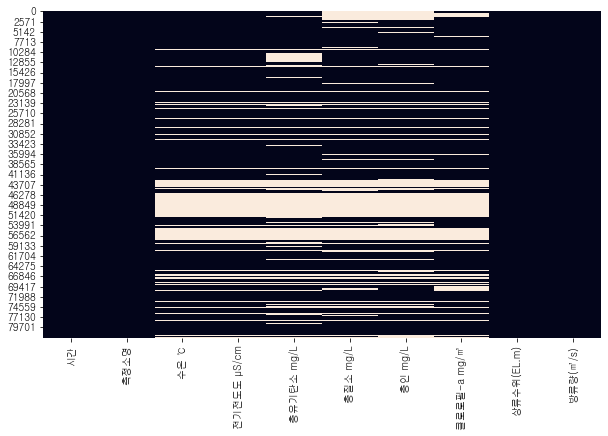

In [42]:
sns.heatmap(scb_data.isnull(), cbar=False)
plt.show()

수치형 특성 결측치들 사이의 피어슨 상관관계를 살펴본다.

- `'상류수위'`와 `'방류량'` 을 제외한 나머지 특성들 사이의 상관관계 정도가 매우 높음.
- `'상류수위'`와 `'방류량'`의 상관관계 지수가 1임. 둘중에 하나 삭제 가능?

In [43]:
scb_data_numeric = scb_data.iloc[:, 2:]
scb_data_numeric.isnull().corr(method='pearson')

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
수온 ℃,1.000000,0.997627,0.784735,0.771253,0.753176,0.893317,-0.005975,-0.005975
전기전도도 μS/cm,0.997627,1.000000,0.784629,0.770361,0.752133,0.891512,-0.005996,-0.005996
총유기탄소 mg/L,0.784735,0.784629,1.000000,0.698539,0.677277,0.726571,-0.005223,-0.005223
총질소 mg/L,0.771253,0.770361,0.698539,1.000000,0.884298,0.771919,-0.007758,-0.007758
총인 mg/L,0.753176,0.752133,0.677277,0.884298,1.000000,0.747514,-0.008128,-0.008128
클로로필-a mg/㎥,0.893317,0.891512,0.726571,0.771919,0.747514,1.000000,-0.006649,-0.006649
상류수위(EL.m),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000
방류량(㎥/s),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000


## 수온 shift 데이터 추가

재활용을 위해 통합 데이터를 복제해서 사용한다.

In [44]:
scb_df = scb_data.copy()  # deep copy

**수온 shift 특성 추가**

시간별로 쉬프트된 과거 수온 정보가 현재의 클로로필-a 예측에 기여하는 정도도 함께 측정한다.
shift 대상은 다음과 같다.

- 0 ~ 24시간 이전: 2시간 단위
- 24 ~ 76시간 이전: 6시간 단위

In [45]:
shift_step = list(range(2, 24, 2)) \
             + list(range(24, 73, 6))

shift_step

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 54, 60, 66, 72]

**쉬프트 특성 추가 함수**

`feature_shifting()` 함수는 특정 특성을 대상으로 shift 적용한 특성을 추가한다.
함수의 인자로 다음 세 개의 값을 받는다.

- `df`: 기존 데이터프레임
- `feature`: shift 대상 특성
- `shift_step`: 추가할 shift 스텝의 리스트

In [46]:
from pandas import DataFrame
import re

def feature_shifting(df : DataFrame, feature : str, shift_step : list) -> None:
    feature_ = re.split(' |\(', feature)[0] # 특성 이름에 사용된 단위 삭제. 공백 또는 여는 괄호 기준 쪼개기

    new_features = dict()
    for step in shift_step:
        new_features[str(step) + 'shift ' + feature_] = df[feature].shift(step)
    
    new_features = pd.DataFrame(new_features)

    return pd.concat([df, new_features], axis=1)

In [47]:
scb_df = feature_shifting(scb_df, '수온 ℃', shift_step)

In [48]:
scb_df.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온',
       '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온',
       '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온',
       '24shift 수온', '30shift 수온', '36shift 수온', '42shift 수온', '48shift 수온',
       '54shift 수온', '60shift 수온', '66shift 수온', '72shift 수온'],
      dtype='object')

shift 된 데이터가 추가되기에 그에 상응해서 결측치도 많아진다.

In [49]:
scb_df.isnull().sum()

시간                 0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
2shift 수온      17685
4shift 수온      17687
6shift 수온      17689
8shift 수온      17691
10shift 수온     17693
12shift 수온     17695
14shift 수온     17695
16shift 수온     17697
18shift 수온     17699
20shift 수온     17701
22shift 수온     17703
24shift 수온     17705
30shift 수온     17711
36shift 수온     17717
42shift 수온     17723
48shift 수온     17729
54shift 수온     17735
60shift 수온     17741
66shift 수온     17747
72shift 수온     17753
dtype: int64

**결측치 보간법 적용**

In [50]:
from datetime import datetime

- 시간 특성을 `datetime` 자료형으로 변환 

In [51]:
scb_df['시간'] = scb_df['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))
# scb_df['시간'] = scb_df['시간'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

12시간 정도까지의 기간동안 존재하는 결측치는 보간법으로 채운다.

In [52]:
scb_df = scb_df.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')

12시간 보다 긴 시간동의 결측치는 제거한다.

In [53]:
scb_df = scb_df.dropna()

In [54]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57002 entries, 2013-03-29 04:00:00 to 2022-05-23 23:00:00
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         57002 non-null  object 
 1   수온 ℃         57002 non-null  float64
 2   전기전도도 μS/cm  57002 non-null  float64
 3   총유기탄소 mg/L   57002 non-null  float64
 4   총질소 mg/L     57002 non-null  float64
 5   총인 mg/L      57002 non-null  float64
 6   클로로필-a mg/㎥  57002 non-null  float64
 7   상류수위(EL.m)   57002 non-null  float64
 8   방류량(㎥/s)     57002 non-null  float64
 9   2shift 수온    57002 non-null  float64
 10  4shift 수온    57002 non-null  float64
 11  6shift 수온    57002 non-null  float64
 12  8shift 수온    57002 non-null  float64
 13  10shift 수온   57002 non-null  float64
 14  12shift 수온   57002 non-null  float64
 15  14shift 수온   57002 non-null  float64
 16  16shift 수온   57002 non-null  float64
 17  18shift 수온   57002 non-null  float64
 18  20shift 수온 

**훈련 특성과 타깃**

먼저 `'시간'` 속성을 훈련 대상에 제외한다.

In [55]:
col = list(scb_df.columns[1:])

`'클로로필-a mg/㎥'` 속성은 타깃 속성으로 제외한다.
나머지 특성을 이용하여 타깃(클로로필-a) 값을 예측할 때 가장 중요한 특성을 확인한다.

In [56]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

## 모델 훈련

먼저 특성 정규화없이 진행한다.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [58]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [59]:
gb_grid.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.749 total time=  22.5s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.748 total time=  22.9s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.735 total time=  22.3s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time=  44.0s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.924 total time=  44.0s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time=  44.0s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.943 total time= 1.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.945 total time= 1.1min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.943 total time= 1.1min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.791 total time=  22.4s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.792 total time=  22.4s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [60]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [61]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.943937,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.943501,2
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.943158,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.941930,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937623,5


In [62]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [63]:
estimator = gb_grid.best_estimator_

**최선 모델 저장**

In [64]:
import joblib

shift_feature = "수온"
joblib.dump(estimator, "승촌보_수온_48shift_best_비표준화.pkl")

['승촌보_수온_48shift_best_비표준화.pkl']

저장된 모델을 다시 불러온다.

In [65]:
estimator = joblib.load("승촌보_수온_48shift_best_비표준화.pkl")

In [66]:
pred = estimator.predict(X_test)

In [67]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.04 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.1 2shift 수온
0.03 4shift 수온
0.01 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.01 24shift 수온
0.01 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.02 60shift 수온
0.02 66shift 수온
0.02 72shift 수온


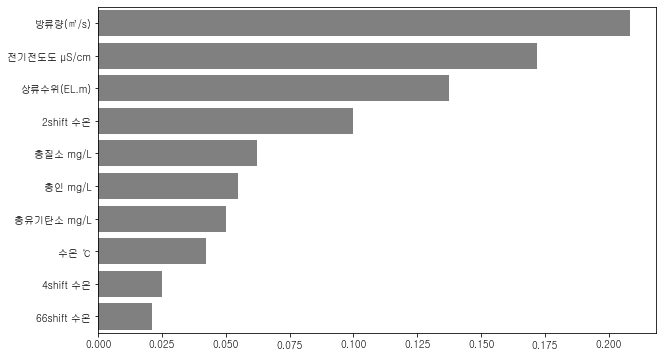

In [68]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [69]:
feature_series[:10]

방류량(㎥/s)       0.208181
전기전도도 μS/cm    0.172090
상류수위(EL.m)     0.137524
2shift 수온      0.099806
총질소 mg/L       0.062059
총인 mg/L        0.054695
총유기탄소 mg/L     0.049990
수온 ℃           0.042197
4shift 수온      0.025087
66shift 수온     0.021257
dtype: float64

In [70]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9632928883346922


피처 정규화

In [71]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [72]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),2shift 수온,4shift 수온,6shift 수온,...,22shift 수온,24shift 수온,30shift 수온,36shift 수온,42shift 수온,48shift 수온,54shift 수온,60shift 수온,66shift 수온,72shift 수온
0,-0.583879,-0.517932,-0.938145,0.222144,-0.225036,0.778067,-0.198824,-0.509093,-0.459184,-0.434192,...,-0.708055,-0.683085,-0.608145,-0.421054,-0.692148,-0.757565,-0.732488,-0.557855,-0.819854,-0.882173
1,-0.596330,-0.517932,-1.035787,0.222144,-0.225036,0.778067,-0.199062,-0.533995,-0.484085,-0.434192,...,-0.708055,-0.695533,-0.620598,-0.433510,-0.639214,-0.757565,-0.732488,-0.607706,-0.757555,-0.894629
2,-0.621232,-0.517932,-1.035787,0.222144,-0.225036,0.778067,-0.198824,-0.583799,-0.508985,-0.459093,...,-0.708055,-0.707981,-0.633051,-0.495790,-0.586279,-0.770021,-0.732488,-0.657556,-0.695256,-0.907086
3,-0.658586,-0.540930,-1.035787,0.222144,-0.225036,0.774235,-0.204930,-0.596249,-0.533886,-0.483993,...,-0.670714,-0.707981,-0.645504,-0.570525,-0.533344,-0.770021,-0.744949,-0.694944,-0.632956,-0.907086
4,-0.671038,-0.563928,-1.035787,0.222144,-0.225036,0.766571,-0.218570,-0.621151,-0.583688,-0.508893,...,-0.620926,-0.707981,-0.657957,-0.607893,-0.458613,-0.770021,-0.757409,-0.682481,-0.570657,-0.894629


In [73]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [74]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3, verbose=5)

In [75]:
gb_grids.fit(X_trains, np.log1p(y_trains))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.749 total time=  22.6s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.747 total time=  22.5s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.735 total time=  22.5s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time=  44.5s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.925 total time=  44.7s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time=  44.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.943 total time= 1.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.945 total time= 1.1min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.943 total time= 1.1min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.791 total time=  22.5s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.792 total time=  22.6s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [76]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [77]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.943735,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.943334,2
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.943146,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.941764,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937686,5


In [78]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [79]:
estimators = gb_grids.best_estimator_

최선의 모델을 저장한다.

In [80]:
import joblib

shift_feature = "수온"
joblib.dump(estimator, "승촌보_수온_48shift_best_표준화.pkl")

['승촌보_수온_48shift_best_표준화.pkl']

저장된 모델을 다시 불러온다.

In [81]:
estimator = joblib.load("승촌보_수온_48shift_best_표준화.pkl")

In [82]:
preds = estimators.predict(X_tests)

In [83]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.04 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.1 2shift 수온
0.03 4shift 수온
0.01 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.01 24shift 수온
0.01 30shift 수온
0.01 36shift 수온
0.01 42shift 수온
0.01 48shift 수온
0.01 54shift 수온
0.02 60shift 수온
0.02 66shift 수온
0.02 72shift 수온


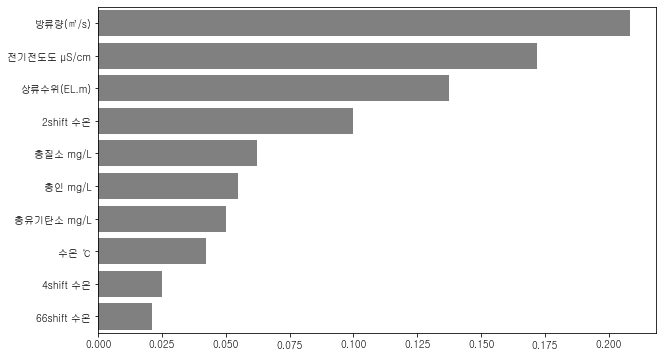

In [84]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [85]:
feature_seriess[:10]

방류량(㎥/s)       0.208181
전기전도도 μS/cm    0.172090
상류수위(EL.m)     0.137524
2shift 수온      0.099806
총질소 mg/L       0.062059
총인 mg/L        0.054695
총유기탄소 mg/L     0.049990
수온 ℃           0.042197
4shift 수온      0.025087
66shift 수온     0.021257
dtype: float64

In [86]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9633798891941563
